<a href="https://colab.research.google.com/github/Egeny-aa/Deep_Learning/blob/main/Kaggle_competitions/Computer_Vision/Segmentation/HUBMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Задача соревнования https://www.kaggle.com/competitions/hubmap-organ-segmentation обучить алгоритм, который сегментирует медицинские снимки некоторых человеческих органов

In [ ]:
! mkdir ~/.kaggle # Создать каталог с именем “.kaggle”:
! cp kaggle.json ~/.kaggle/ # Скопировать файл “kaggle.json” в созданный каталог:
! chmod 600 ~/.kaggle/kaggle.json #Назначить необходимое разрешение для этого файла 

In [ ]:
! kaggle competitions download -c hubmap-organ-segmentation

In [ ]:
! ls / hubmap-organ-segmentation.zip

In [ ]:
! unzip hubmap-organ-segmentation.zip -d/Data_comp

In [ ]:
! ls /Data_comp

In [ ]:
!pip install segmentation-models-pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U albumentations

In [ ]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from google.colab.patches import cv2_imshow
import torch 
from torchvision import transforms
from  torch.utils.data import Dataset, DataLoader, RandomSampler
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, RandomRotate90, Compose, GaussNoise, GridDistortion)

import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

from albumentations import (HorizontalFlip, Normalize, Compose, GaussNoise, RandomRotate90, Transpose)
from albumentations.pytorch import ToTensorV2


import time

seed = 42
np.random.seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed) 
  torch.manual_seed(seed) 


In [ ]:
train_csv_data = pd.read_csv('/Data_comp/train.csv') # Столбец Rle Копия анатационного(json) 
test_csv_data = pd.read_csv('/Data_comp/test.csv')
path_img = '/Data_comp/train_images' 

In [ ]:
total_w, total_h = train_csv_data[['img_height','img_width']].value_counts().to_frame().index[0]

In [ ]:
train_image_list = os.listdir('/Data_comp/train_images')
train_annotation = os.listdir('/Data_comp/train_annotations')

In [ ]:
train_csv_data.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [ ]:
train_csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.5+ KB


В датасете отсутствуют Nan-значения

Дополнять его не нужно

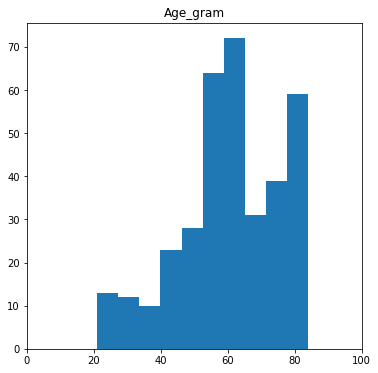

In [ ]:
plt.figure(figsize = (6,6))
plt.title("Age_gram")
plt.hist(train_csv_data.age)
plt.xlim(0,100)
plt.show()

In [ ]:
img_name = Image.open('/Data_comp/train_images/' + train_image_list[0])

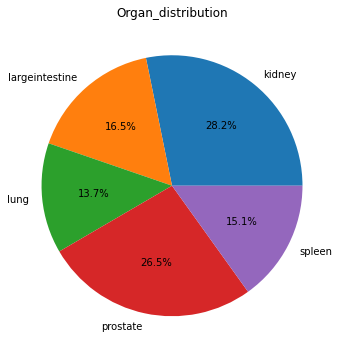

In [ ]:
labels = np.array(train_csv_data.groupby(['organ']).count()['id'].index)
data_organ = np.array(train_csv_data.groupby(['organ']).count()['id'])
plt.figure(figsize = (6,6))
plt.title('Organ_distribution')
plt.pie(data_organ, labels = labels, autopct = '%1.1f%%')
plt.show()

In [ ]:
 train_csv_data[['img_height','img_width']].value_counts().to_frame()

0
img_height img_width     
3000       3000       326
2764       2764         2
2942       2942         2
2631       2631         2
2654       2654         2
2790       2790         2
2416       2416         2
2308       2308         1
2869       2869         1
2867       2867         1
2783       2783         1
2727       2727         1
2760       2760         1
2680       2680         1
2675       2675         1
2630       2630         1
2593       2593         1
2539       2539         1
2511       2511         1
3070       3070         1

In [ ]:
train_csv_data['data_source'].value_counts().to_frame()

data_source
HPA          351

In [ ]:
train_csv_data['pixel_size'].value_counts().to_frame()

pixel_size
0.4         351

In [ ]:
train_csv_data['tissue_thickness'].value_counts().to_frame()

tissue_thickness
4               351

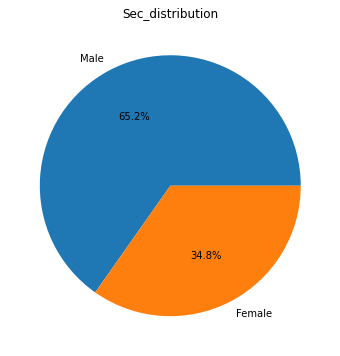

In [ ]:
plt.figure(figsize = (6,6))
label = np.array(train_csv_data['sex'].value_counts().index)
plt.pie(train_csv_data['sex'].value_counts(),labels=label, autopct = '%1.1f%%')
plt.title("Sec_distribution")
plt.show()

Из диаграмм, полученных выше можно сделать вывод, что распределение классов в датасете неравномерное.

Но так как мы работаем непосредственно с фото срезом некоторого органа человека, то скорее всего эта несбалансированность нам не помешает разработать алгоритм, сегментирующий изображения


Запускать отсюда


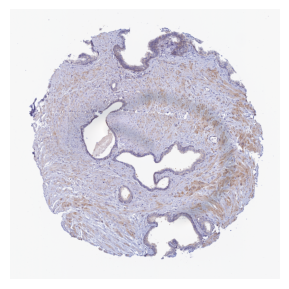

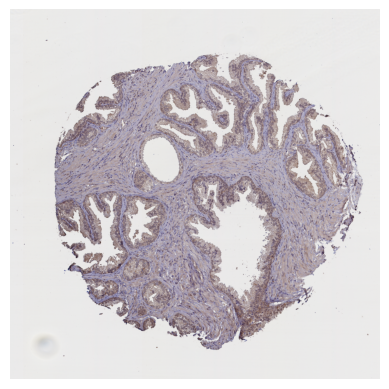

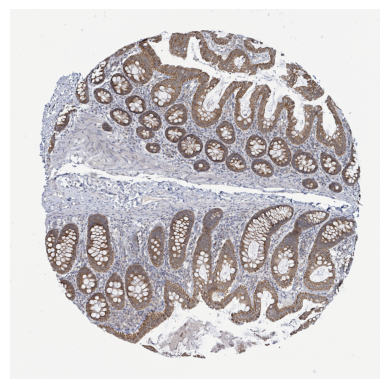

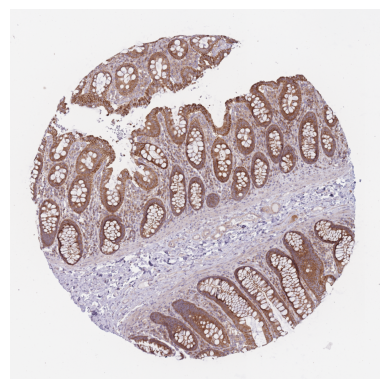

In [ ]:
def open_img(img_tr, ann_tr, num_img):
  indices = np.random.choice(np.arange(len(img_tr)), num_img, False)

  fig = plt.figure(figsize =(16,16) )
  for i in range(num_img):
    im_t = Image.open( '/Data_comp/train_images/' + img_tr[i])
    fig.add_subplot(1, num_img, i + 1)
    plt.imshow(im_t)
    plt.axis('off')
    plt.show()
    
open_img(train_image_list, train_annotation, 4)

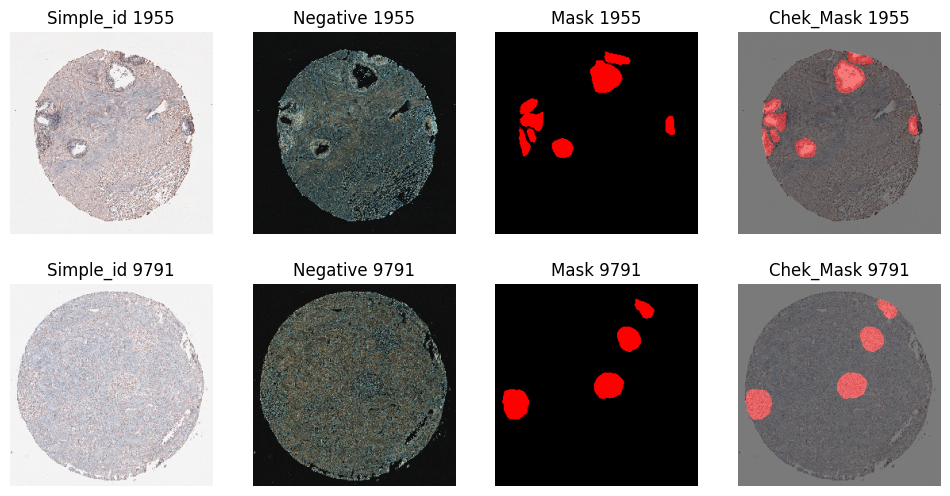

In [ ]:
def open_img(num_imgs):
  # Выводим изображение, его нормализированное состояние, маску т как изображние выглядит на маске 
  indices = np.random.randint(1, len(train_image_list), size = num_imgs)
  fig, ax = plt.subplots(nrows = num_imgs, ncols = 4, figsize= (num_imgs * 6, 6))
    
  for r in range(num_imgs):

    row_id = train_csv_data.iloc[indices[r]].id.squeeze()

    img =  get_img(row_id, 256, 256)   
    
    ax[r,0].imshow(img)
    ax[r,0].set_title(f'Simple_id {row_id}')
    ax[r,0].axis(False)

    neg_img = get_img(row_id,256,256, True)

    ax[r,1].imshow(neg_img)
    ax[r,1].set_title(f'Negative {row_id}')
    ax[r,1].axis(False)

    mask = polug_mask(row_id, 256, 256)

    ax[r,2].imshow(mask * np.array([255,0,0], dtype = np.uint8()))
    ax[r,2].set_title(f'Mask {row_id}')
    ax[r,2].axis(False)

    ax[r,3].imshow(img)
    ax[r,3].imshow(mask * np.array([255,0,0], dtype=np.uint8()), alpha = 0.5 )
    ax[r,3].set_title(f'Chek_Mask {row_id}')
    ax[r,3].axis(False)
  plt.show()

open_img(4)

Изображения выше подкрепляют наши рассуждения о том, что нам неважно из какого органа получено данное изображение.

Они все примерно одинаковые

Почти все наши изображения имеют размерность 3000 * 3000 * 3, что дает нам в случаем первого сверточного слоя без paddin, с шагом 2 и размером 2 изображение с H == W == 1500 и некоторой глубиной выхода dout Что дает нам 2 * 2 * 3 * 1500 * 1500 * dout операций(при минимальном d - 21 млн) на первом слое, что довольно много. 
Поэтому ресайзнем изображение до 256 * 256.


P.S Можно и до другого размера. Главное помнить, что (H, W) должны быть кратны 32. Иначе в первых слоях свертки энкодера получится нецелое число пикселей, а это неприемлемо.



In [ ]:
def resize_img(tensor, input_h = 256, input_w = 256):
  # Меняем размер изображения используя кубическую интерполмцию
  return cv2.resize(tensor, [input_h, input_w], interpolation = cv2.INTER_CUBIC)

def polug_mask(img_id, img_h = 256, img_w = 256):
  # Отрисовывыем маску
  row = train_csv_data.query(f'id == {img_id}').squeeze() 
  img_height, img_width = row.img_height, row.img_width
  polugon = row.rle.split() 
  mask = np.zeros([img_height * img_width ], dtype = np.uint8()) 
  #  Выбираем начало каждого пикселя в маске и длину дорожки
  start = np.array([int(x) for x in polugon[0::2]]) 
  lenght = np.array([int(x) for x in polugon[1::2]]) 

  for st,en in zip(start, lenght):
    mask[st: st + en + 1] = 1

  # Делаем двумерное представление маски
  mask = mask.reshape(img_height, img_width).T 
  mask = resize_img(mask, img_h, img_w)
  #  Изображение имеет трехмерную размерность -> а Маска принадлежность 2 классам 1 и 0 -> двумерный массив с 1 каналом 
  mask = np.expand_dims(mask, axis = 2) 
  
  return mask

def get_img(img_id, img_h = 256, img_w = 256, neg = False):
  img = cv2.imread(f'/Data_comp/train_images/{img_id}.tiff')      
  img = resize_img(img, img_h, img_w)
  #  Нормализуем изображение, если стоит соответствующий флаг
  if neg:
    img = img - img.min()
    img = img / (img.max() - img.min())
    img = img * 255
    img = 255 - img.astype(np.uint8())

  return img

In [ ]:
class lim_ysels(Dataset):
  """Класс для инициализации данных, их аугументации, и перебора для DataLoader"""
  
  def __init__(self, csv_set, transforms = False):
    self.csv_set = csv_set
    self.transforms = transforms

  def __len__(self):
    return len(self.csv_set)

  def __getitem__(self, index):

    if torch.is_tensor(index):
      index = index.tolist()

    row = self.csv_set.iloc[index]
    img_id = row.id

    #Получаем изображение и маску
    img = get_img(img_id) 
    mask = polug_mask(img_id)
    
    #Применяем к ним аугументацию
    if self.transforms:
      augmentation = self.transforms(image = img, mask = mask)
      aug_img = augmentation['image']
      aud_mask = augmentation['mask']

    # Перевод изображений в тензор обязателен для обучения NC, производиться в ручною без ToTensor()
    image = aug_img.transpose(2, 0, 1)
    mask = aud_mask.transpose(2, 0, 1)
    
    image_tensor = torch.from_numpy(image.astype(np.float32))
    mask_tensor = torch.from_numpy(mask.astype(np.float32))


    return image_tensor, mask_tensor

In [ ]:
def choice_set(ds, train = True):
  #  Разбиваем датасет на тренировочный и валидационный 80 и 20
 
  train_ds, val_ds = train_test_split(ds, test_size = 0.2, random_state = seed)
  transform_list = [Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]
  #  Аугментацию применяем только для тренировочного сета
  if train: 
    transform_list = transform_list + [HorizontalFlip(p = 0.5), GridDistortion(p = 0.5),Transpose(p = 0.5), RandomRotate90(p=0.5), GaussNoise(per_channel = True)] 
    return lim_ysels(train_ds, transforms = Compose(transform_list)) 
  
  else:
    return lim_ysels(val_ds, transforms = Compose(transform_list))

In [ ]:
batch_size = 16
train_df = choice_set(train_csv_data)
val_df = choice_set(train_csv_data, train = False)
# Формируем тренировочный и валидационный лоадеры
train_loader = DataLoader(train_df, batch_size = batch_size, shuffle = True, generator=torch.Generator(device='cuda')) 
val_loader = DataLoader(val_df, batch_size = batch_size * 2, shuffle = True, generator=torch.Generator(device='cuda'))

Напишем функцию для вычисления метрики Dice 

Так же класс для храниния истории лосса и коэфицента Dice

In [ ]:
def Dice_score(target, predict, treshold = 0):
  #  Если значение пикселя больше трешхолда, то он принимает значение 1, иначе 0 
  predict = (predict > treshold).float() 
  
  Dice = 2 * (predict * target).sum() / (predict + target).sum()
  return Dice

class Scores():
  """Класс инициализирующий объект в котором хранится метрика Dice, рассчитанная по всем эпохам.
  """
  def __init__(self):
    self.epoch_train_Dice = {}
    self.epoch_val_Dice = {}
    self.bach_Dice = [] 
    self.tr_ep = 1
    self.val_ep = 1

  def upDice(self, target, predict, treshold = 0.2):
    """Обновляем коэффициент
    """
    dice = Dice_score(target, predict, treshold)
    self.bach_Dice.append(dice) 


  def get_metric(self, stage):
    """Получаем среднюю метрику по эпохе и добавляем коэффициент в тот или иной словарь,
     в зависимости от стадии обучения
    """
    dice = np.mean(self.bach_Dice)
    
    if stage == 'Val':
      self.epoch_val_Dice[self.val_ep] = dice
      self.val_ep += 1
    else:
      self.epoch_train_Dice[self.tr_ep] = dice
      self.tr_ep += 1
    
    return dice

  def delate_epoch(self):
    """Очищаем коэффициенты, накопленные за всю эпоху 
    """
    self.bach_Dice = []

  def get_epoch_Dice(self):
    """Возвращаем средний Dice за всю эпоху
    """
    return  self.epoch_Dice


Напишем класс для тренировки НС

In [ ]:
class Trainer(object):
  '''Класс Trainer используется для обучения и тестирования нейроной сети
    имеет функции
    '''

  def __init__(self, model, loss, train_loader, val_loader, optim, shelder):
    """Инициализация модели и её параметров"""
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.optim = optim 
    self.shelder = shelder   
    self.loss_Train_history = []
    self.loss_Val_history = []
    self.best_loss = float('inf')
    self.score_class = Scores()
    self.val_predicted = {}

    if torch.cuda.is_available():
      self.device = torch.device('cuda:0') 
  
      torch.set_default_tensor_type("torch.cuda.FloatTensor")
      cudnn.benchmark= True # 
    else:
      self.device = self.device("cpu")
    
    self.loss = loss
    self.net = model.to(self.device) 
    
  def forward(self, img, mask, combine):
    """Делаем прямой проход по нейронной сети
    """
    #Подаем изображение и маску для него на соответствующий Device
    #Мы не сможем обучать нейронную сеть, если она сама будет на CPU, а объекты, на которых она будет обучаться на GPU
    img_gpu = img.to(self.device, dtype = torch.float)
    mask_gpu = mask.to(self.device, dtype = torch.float)
    
    predict_mask = self.net(img_gpu) 
    
    # Если хотим использовать комбинированную функцию потерь, то поставить флаг combine = True
    if combine:
      losses = binery_combine_loss(smp.losses.SoftBCEWithLogitsLoss(), smp.losses.DiceLoss('binary'), predict_mask, mask_gpu, 0.2, 0.8)
    else:
      losses = self.loss(predict_mask, mask_gpu) 
 
    return losses, predict_mask

  def train_iter(self, epoch, metrick_class, new_train_loader, combine):
    """Делаем итерацию обучения
       new_val_loader - DataLoader -> Используется если мы хотим обучить нашу нейронную сеть на датасете, который не был заложен в объект Trainer
       metrick_class -> Передаем объект класса Dice_score()
       combine - bool -> True если вместо обычной функции потерь хотим использовать комбинированную
    """
    start_time = time.strftime("%H:%M:%S")

    total_epoch_loss = 0
    # Подготовливаем НС для обучения
    self.net.train() 
    for iter, bach in enumerate(new_train_loader):
      img, mask = bach 
      
      #  Блок непосредственно обучения НС
      self.optim.zero_grad() 
      losses, predict = self.forward(img, mask, combine)
      losses.backward()  
      self.optim.step()

      #  Подсчет метрик и аккумулированного лосса
      total_epoch_loss += losses.item() 
      predict = predict.detach().cpu() 
      metrick_class.upDice(mask, predict, treshold = 0)

    losses = losses / len(new_train_loader)
    get_dice = metrick_class.get_metric('Train')

    print('Loss | %0.3f Dice | %0.3f' % (losses, get_dice) )
    
    #  Переводим лосс с GPU на CPU, для последующей работы с ней
    self.loss_Train_history.append(float(losses.cpu().detach().numpy()))
    
    metrick_class.delate_epoch()
    end_time = time.strftime('%H:%M:%S')
    
    print(f"Start Train: {start_time}, Epoch - {epoch + 1}, End train {end_time}")
    return losses

  def val_iter(self,epoch, metrick_class, new_val_loader, combine):
    """Делаем тестирование на валидационной выборке
       new_val_loader - DataLoader -> Используется если мы хотим протестировать нашу нейронную сеть на датасете, который не был заложен в объект Trainer
       metrick_class - Передаем объект класса Dice_score()
       combine - bool -> Если вместо обычной функции потерь хотим использовать комбинированную
    """
    #  Подготавливаем НС для тестирования
    self.net.eval()
    total_loss = 0

    for iter, bach in enumerate(new_val_loader):
      img, mask = bach
      
      losses, pred = self.forward(img, mask, combine)

      total_loss += losses.item()
      pred = pred.detach().cpu()
      metrick_class.upDice(mask, pred)

    # Считаем метрику и функцию потерь для всей эпохи
    get_dice = metrick_class.get_metric('Val')
    metrick_class.delate_epoch()

    losses = total_loss / len(new_val_loader)
    self.loss_Val_history.append(float(losses))
    
    print('Val_loss | %0.3f, Val_dice | %0.3f' % (losses, get_dice))
    
    return losses, pred, mask

  def start_learn(self, epoch):
    """Запускаем обучение
    """
    for ep in range(epoch):
      
      loss = self.train_iter(ep, self.score_class, self.train_loader, True)

      #  Отключаем вычисление градиенттов
      with torch.no_grad():

        val_loss, val_pred_mask, mask = self.val_iter(ep, self.score_class, self.val_loader, True)
        
        #  Сохраянем последние предсказанную и таргетную маски 
        self.val_predicted[ep]  = (val_pred_mask[0], mask[0])
        self.shelder.step()

    #  Сохраяем параметры оптимизатора и модели 
    state = {'state_dict': self.net.state_dict(),
           'optimizer': self.optim.state_dict()}
  
    torch.save(state,'<path>')

In [ ]:
def DoTrainAnotherSet(model_train_obj,curnet_epoch, end_epoch, train_loader, val_loader, combine):
  """ Проводим дообучение нейронной сети.
      Либо на навом датасете, либо на старом, в случае ее потенциала к обучению
  """

  for i in range(curnet_epoch, end_epoch + 1):
    
    model_train_obj.train_iter(i, model_train_obj.score_class, train_loader, True)
    model_train_obj.val_iter(i, model_train_obj.score_class, val_loader, True) 

  #  Сохраняем параметры модели и оптимизатора 
  state = {'state_dict': model_train_obj.model.state_dict(),
           'optimizer': model_train_obj.optim.state_dict()}

  torch.save(state,'<path>')

  print('Дообучение нейронной сети завершено')

  return model_train_obj

In [ ]:
model_1 = smp.Unet(encoder_name="resnet50", 
                 encoder_weights="imagenet", 
                 in_channels=3, 
                 classes=1)

model_2 = smp.DeepLabV3(encoder_name="resnet50", 
                 encoder_weights="imagenet", 
                 in_channels=3, 
                 classes=1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 326MB/s]


In [ ]:
def binery_combine_loss(loss1, loss2, pred,true, alpha = 0.5, betta = 0.5): 
  return alpha * loss1(pred, true) + betta * loss2(pred, true)

In [ ]:
def choice_params_for_learning(model): 
  """
  Реализация Random Search
  """
  #  Выбираем из равномерного распределения 
  lr = np.random.uniform(1e-2, 6e-4)
  wight_decay = np.random.uniform(lr * 0.01, lr * 0.05)

  betas_uni = np.random.uniform(0.6, 0.89)
  betas = (betas_uni, betas_uni + 0.099) 
  eps = np.random.uniform(1e-7, 1e-9)
  
  optimazer = np.random.choice([optim.Adam(model.parameters(),lr=lr, betas = betas, eps=eps, weight_decay = wight_decay, capturable = True),           
                                torch.optim.AdamW(model.parameters(),lr=lr, betas = betas, eps=eps, weight_decay = wight_decay, capturable = True)])
  
  gamma = np.random.uniform(0.5, 0.95)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimazer, gamma=gamma, verbose=False)

  return optimazer, scheduler 



In [ ]:
class Search_best_model():
  """Класс, реализованный для выбора лучших ГП для выбранной модели НС
     Хранит историю обучения всех моделей
  """
  def __init__ (self, num_model, model, loss, train_loader,val_loader,num_epoch):
    self.num_model = num_model
    self.model = model
    self.loss = loss
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.num_epoch = num_epoch
    self.models_train_objct = {}

  def start_train_models(self, flag):
    
    for i in range(1, self.num_model + 1):
      optim, shel = choice_params_for_learning(self.model)  
    
      train = Trainer(self.model, self.loss, self.train_loader, self.val_loader, optim, shel)
      train.start_learn(self.num_epoch)

      self.models_train_objct[i] = train
      
      #  Сохраняем параметры модели и оптимизатора
      state = {
                "state_dict": train.net.state_dict(), 
                "optimizer": train.optim.state_dict(), 
            }
      #  Флаг отвечает за то, какую архитектуру сохраняем 
      if flag:
        torch.save(state,'<>')
      else:
        torch.save(state,'<>')
      
      print(f'Обучение {i} модели завершено')


In [ ]:
def present_model_train_score(model_train_loss, model_val_loss, MODEL_COUNT):
  """
  Функция, которая выводит графики функции потерь на обучении и на валидации для каждой модели  
  """
  fig, ax = plt.subplots(nrows = MODEL_COUNT, ncols = 2, figsize = (10, 4 * MODEL_COUNT))

  for r in range(MODEL_COUNT):

    ax[r, 0].plot(model_train_loss[r], color='red')
    ax[r, 1].plot(model_val_loss[r], color='darkred')

    ax[r, 0].set_title(f'Train_history of traning {r + 1} model')
    ax[r, 1].set_title(f'Val_history of traning {r + 1} model')
  plt.show()


In [ ]:
def model_visual_traning_history(model_val_mask_img, EPOCH_COUNT):
  """  Функция, которая выводит предикаты модели и правильные маски для каждой эпохи на валидации 
  """

  fig, ax = plt.subplots(nrows = EPOCH_COUNT, ncols = 2, figsize = (3,EPOCH_COUNT * 2))

  for c in range(EPOCH_COUNT):
    
    ax[c,0].imshow(model_val_mask_img[c][0].reshape(256,256,1))
    ax[c,0].axis(False)
    ax[c,0].set_title('Val')

    ax[c,1].imshow(model_val_mask_img[c][1].reshape(256,256,1))
    ax[c,1].axis(False)
    ax[c,1].set_title('Grd_true')
  plt.show()

In [ ]:
# Search_best_model -> .model_tarin_objct[i] -> .score_class -> Train + Val loss_history + Коэфицен Дайс по каждой эпохи + коэфицент дайс по всем эпохам и это все для каждой модели

Обучим 10 НС U_Net и выберем лучшую для обучения на аугментационной данных с комбинированной функцией потерь


In [ ]:
# Обучение заняло 2ч 55 мин
MODEL_COUNT = 10
EPOCH_COUNT = 10
search_model = Search_best_model(MODEL_COUNT, model_1, loss, train_loader, val_loader, EPOCH_COUNT)
search_model.start_train_models()

Loss | 0.029 Dice | 0.000
Start Train: 13:30:26, Epoch - 1, End train13:31:50
Val_loss | 0.707, Val_dice | 0.325
******** New optimal found, saving state ********
Loss | 0.030 Dice | 0.000
Start Train: 13:32:15, Epoch - 2, End train13:33:32
Val_loss | 0.540, Val_dice | 0.000
******** New optimal found, saving state ********
Loss | 0.030 Dice | 0.015
Start Train: 13:33:55, Epoch - 3, End train13:35:12
Val_loss | 0.698, Val_dice | 0.298
Loss | 0.027 Dice | 0.141
Start Train: 13:35:30, Epoch - 4, End train13:36:47
Val_loss | 0.490, Val_dice | 0.372
******** New optimal found, saving state ********
Loss | 0.024 Dice | 0.225
Start Train: 13:37:09, Epoch - 5, End train13:38:26
Val_loss | 0.568, Val_dice | 0.413
Loss | 0.028 Dice | 0.260
Start Train: 13:38:44, Epoch - 6, End train13:39:58
Val_loss | 0.458, Val_dice | 0.327
******** New optimal found, saving state ********
Loss | 0.027 Dice | 0.278
Start Train: 13:40:20, Epoch - 7, End train13:41:36
Val_loss | 0.484, Val_dice | 0.181
Loss | 0.

In [ ]:
model_train_loss = []
model_val_loss = []

for i in range(MODEL_COUNT):
  model_train_loss.append(search_model.models_train_objct[i + 1].loss_Train_history)
  model_val_loss.append(search_model.models_train_objct[i + 1].loss_Val_history)

Ниже представлены графики обучения 10 нейронных сетей U-net на датасете без аугментационной данных

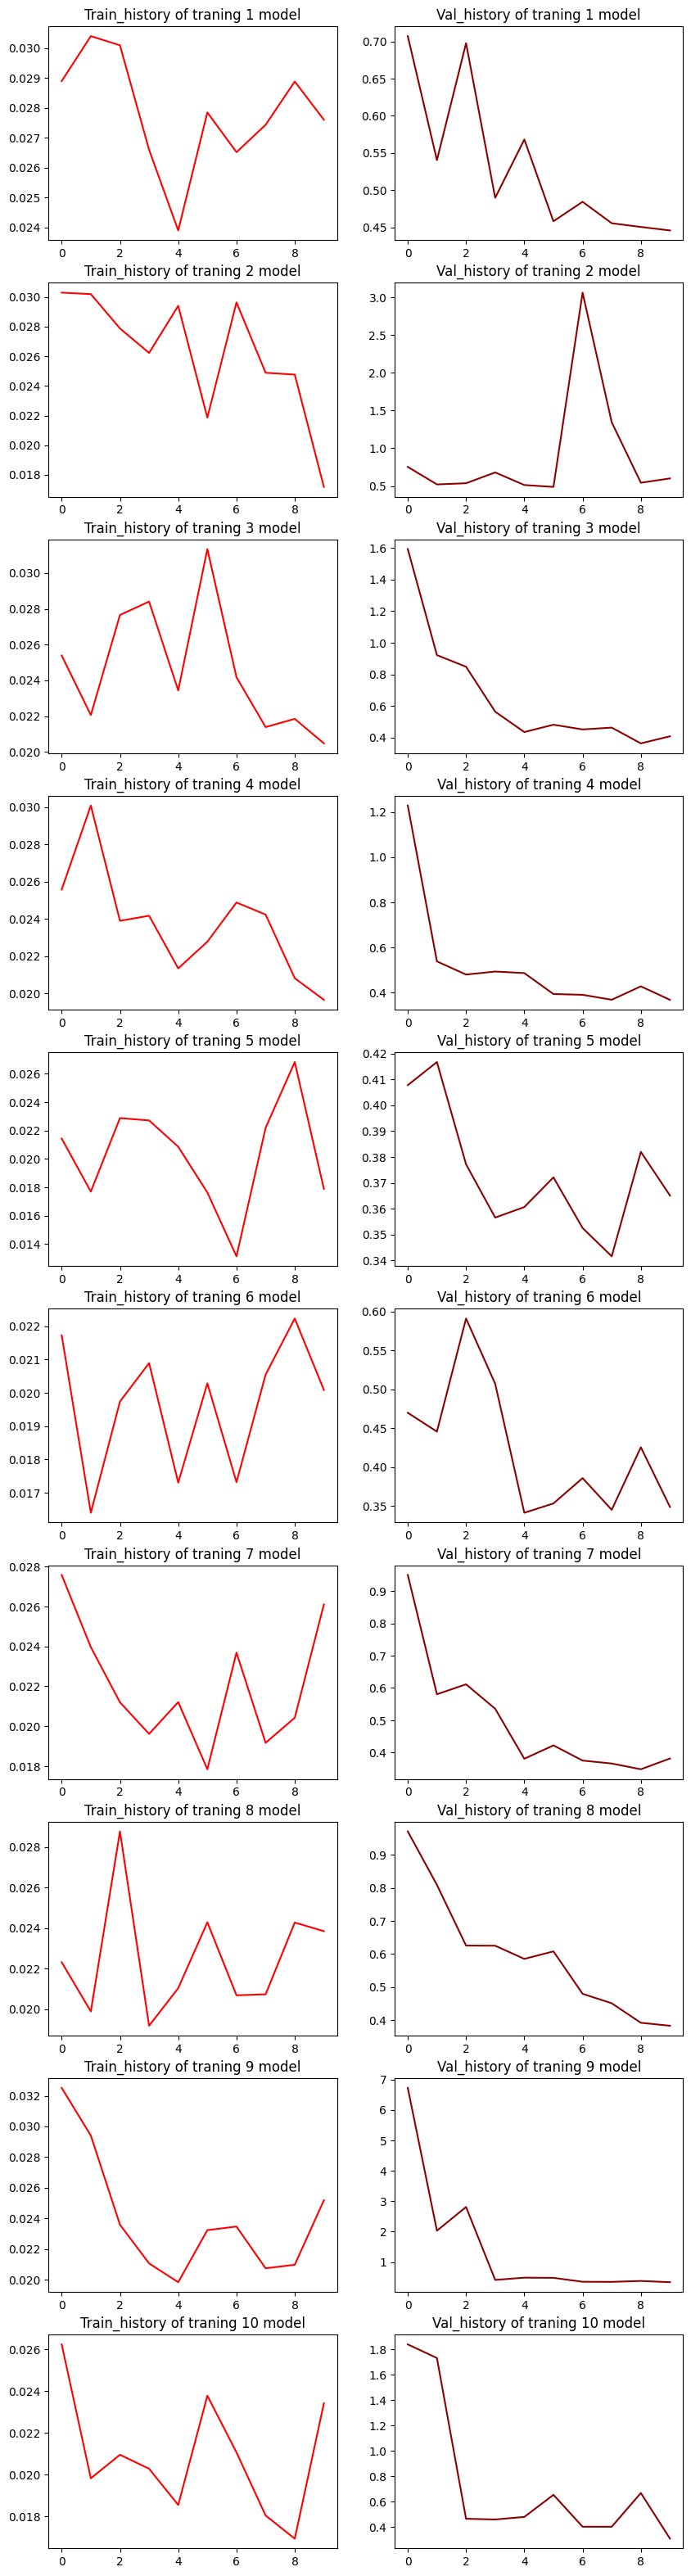

In [ ]:
present_model_train_score(model_train_loss, model_val_loss, MODEL_COUNT)

По графикам обучения можно сказать, что модели 4, 8, 3 можно дообучить.

С их гиперпараметрами обучение проходило гладко, без скачков


Ниже представлены предсказанные нашей сетью сегментационные маски на валидационном датасете. Видно, что нейронная сеть что-то выучила, но совсем не идеально. Есть такие изображения, где все замазано желтым, а сегментированный объект очень мал. Лучше всех, как мне кажется справляется с задачей нейронная сеть №8. Дообучать будем ее.



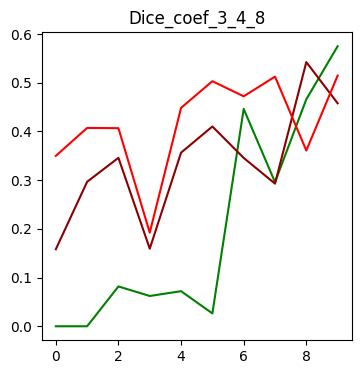

In [ ]:
plt.figure(figsize = (4,4))
plt.plot(search_model.models_train_objct[8].score_class.epoch_val_Dice.values(),color='green')
plt.plot(search_model.models_train_objct[3].score_class.epoch_val_Dice.values(), color='darkred')
plt.plot(search_model.models_train_objct[4].score_class.epoch_val_Dice.values(), color='red')
plt.title('Dice_coef_3_4_8')
plt.show()

Как видно из графиков, коэфициент Dice самый высокий как раз у модели под номером 8 (из этих 3х, а так лучший метрика была у 10 модели - 0.602)

Dice = 0.575

In [ ]:
#  Параметры оптимизатора 8 модели
search_model.models_train_objct[8].optim.state_dict()['param_groups']

[{'lr': 0.001371667751309433,
  'betas': (0.605491130858883, 0.614491130858883),
  'eps': 8.031460199520828e-08,
  'weight_decay': 0.0027732263300247126,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': True,
  'differentiable': False,
  'fused': None,
  'initial_lr': 0.007211862340178638,
  'params': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   

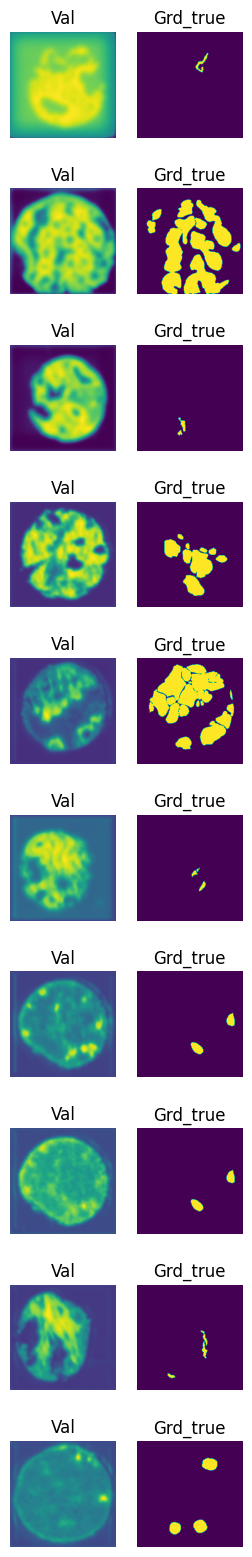

In [ ]:
model_visual_traning_history(search_model.models_train_objct[3].val_predicted, EPOCH_COUNT)

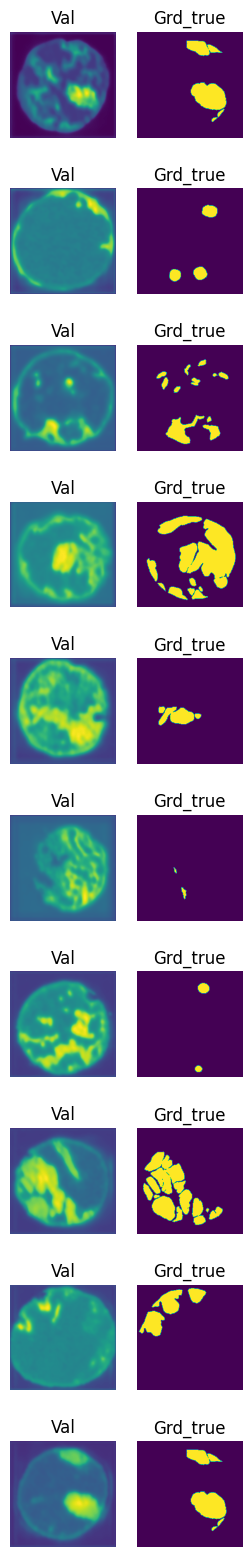

In [ ]:
model_visual_traning_history(search_model.models_train_objct[4].val_predicted, EPOCH_COUNT)

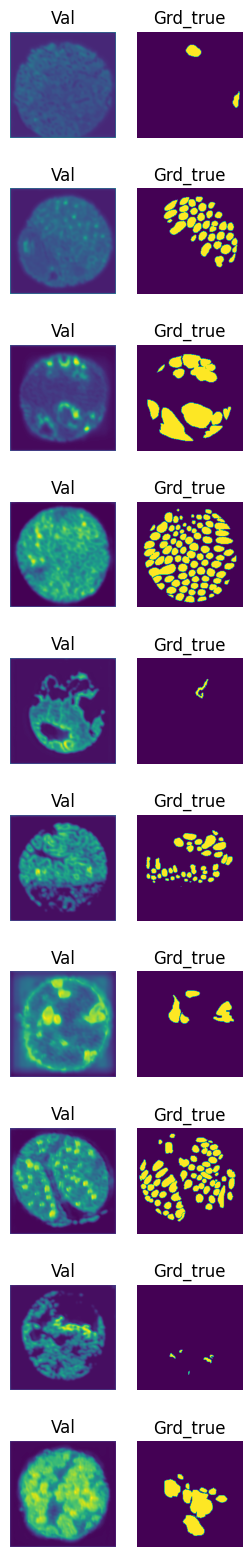

In [ ]:
model_visual_traning_history(search_model.models_train_objct[8].val_predicted, EPOCH_COUNT)

Обучим новую нейронную сеть - U_NET
Так получилось, что я не прописал в коде сохранения моделей после обучения(уже это исправил)

Из пaраметров оптимизатора возьмем только learning_rate = 0.007211862340178638 и weight_decay = 0.0027732263300247126.

Мне кажется, что я зря рандомным поиском выбирал другие параметры(betas и esp).
Посмотрел код других людей - никто так не делал. Поэтому в этот раз мы оставим их без изменений.


При этом я обучал на данных без аугументации. Если дообучать на данных с аугументацией, то нейросеть, скорее всего переобучится. Она уже видила львиную долю примеров на N эпох.

Поэтому в этот раз будем обучать сразу на данных с аугументацией.

Попробуем обучить нейросеть на 24 эпохах





In [ ]:
optimazer = torch.optim.Adam(model_1.parameters(), lr=0.007211862340178638, weight_decay = 0.0003)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimazer, gamma=0.6, verbose=True)

train = Trainer(model_1, loss = None, train_loader = train_loader, val_loader = val_loader, optim = optimazer, shelder = scheduler) # функция потерь комбинированная, выбирается в самом классе

In [ ]:
train.start_learn(24)

Loss | 0.042 Dice | 0.304
Start Train: 16:12:49, Epoch - 1, End train 16:13:58
Val_loss | 0.770, Val_dice | 0.223
Adjusting learning rate of group 0 to 2.5271e-03.
Loss | 0.035 Dice | 0.316
Start Train: 16:14:13, Epoch - 2, End train 16:15:19
Val_loss | 0.574, Val_dice | 0.433
Adjusting learning rate of group 0 to 1.5163e-03.
Loss | 0.040 Dice | 0.312
Start Train: 16:15:35, Epoch - 3, End train 16:16:39
Val_loss | 0.581, Val_dice | 0.427
Adjusting learning rate of group 0 to 9.0976e-04.
Loss | 0.031 Dice | 0.345
Start Train: 16:16:55, Epoch - 4, End train 16:17:59
Val_loss | 0.573, Val_dice | 0.392
Adjusting learning rate of group 0 to 5.4586e-04.
Loss | 0.034 Dice | 0.352
Start Train: 16:18:14, Epoch - 5, End train 16:19:18
Val_loss | 0.569, Val_dice | 0.415
Adjusting learning rate of group 0 to 3.2751e-04.
Loss | 0.028 Dice | 0.344
Start Train: 16:19:34, Epoch - 6, End train 16:20:38
Val_loss | 0.562, Val_dice | 0.418
Adjusting learning rate of group 0 to 1.9651e-04.
Loss | 0.036 Dic

Как можно заметить, метрика Dice, как и функция потерь не стали лучше, по сравнению с первыми 10 эпохами обучения.
По этой причине кривые и изображения предсказанных масок этой нейронной сети выводить не стал.


По графикам обучения сетей U-Net сложно(но можно) сказать какие из них переобучились, а у каких есть потенциал дообучиться. 
Это из-за маленького количества эпох обучения.
Поэтому в этот раз увеличим количество эпох обучения в 2 раз, и сократим кол-во нейронок в 2 раза. В сумме у нас останется 100 эпох обучения.


При такое расскладе мы не сможем охватить больший пул гиперпараметров, но сможем сделать более корректные выводы по поводу переобучения нейронных сетей по сравнению с 1 экспериментом.


In [ ]:
#Время обучения составило 3ч 5 минут
MODEL_COUNT = 5
EPOCH_COUNT = 20
loss = smp.losses.SoftBCEWithLogitsLoss()
search_model = Search_best_model(MODEL_COUNT, model_2, loss, train_loader, val_loader, EPOCH_COUNT)
search_model.start_train_models(flag = True)

Loss | 0.015 Dice | 0.039
Start Train: 13:52:42, Epoch - 1, End train 13:54:32
Val_loss | 2698608.833, Val_dice | 0.000
Loss | 0.020 Dice | 0.000
Start Train: 13:54:52, Epoch - 2, End train 13:56:23
Val_loss | 30.212, Val_dice | 0.000
Loss | 0.012 Dice | 0.000
Start Train: 13:56:41, Epoch - 3, End train 13:58:11
Val_loss | 0.284, Val_dice | 0.000
Loss | 0.019 Dice | 0.000
Start Train: 13:58:29, Epoch - 4, End train 14:00:01
Val_loss | 0.254, Val_dice | 0.000
Loss | 0.021 Dice | 0.000
Start Train: 14:00:20, Epoch - 5, End train 14:01:52
Val_loss | 0.274, Val_dice | 0.000
Loss | 0.013 Dice | 0.000
Start Train: 14:02:11, Epoch - 6, End train 14:03:43
Val_loss | 0.268, Val_dice | 0.000
Loss | 0.011 Dice | 0.000
Start Train: 14:04:03, Epoch - 7, End train 14:05:34
Val_loss | 0.272, Val_dice | 0.000
Loss | 0.017 Dice | 0.000
Start Train: 14:05:54, Epoch - 8, End train 14:07:23
Val_loss | 0.234, Val_dice | 0.000
Loss | 0.014 Dice | 0.000
Start Train: 14:07:42, Epoch - 9, End train 14:09:12
Va

In [ ]:
model_train_loss = []
model_val_loss = []

for i in range(MODEL_COUNT):
  model_train_loss.append(search_model.models_train_objct[i + 1].loss_Train_history)
  model_val_loss.append(search_model.models_train_objct[i + 1].loss_Val_history)

Самое "гладкое" обучение было у 3 модели(видно из графика). 
У нее же самый маленький лосс на валидации после 20 эпох обучения - 0.173



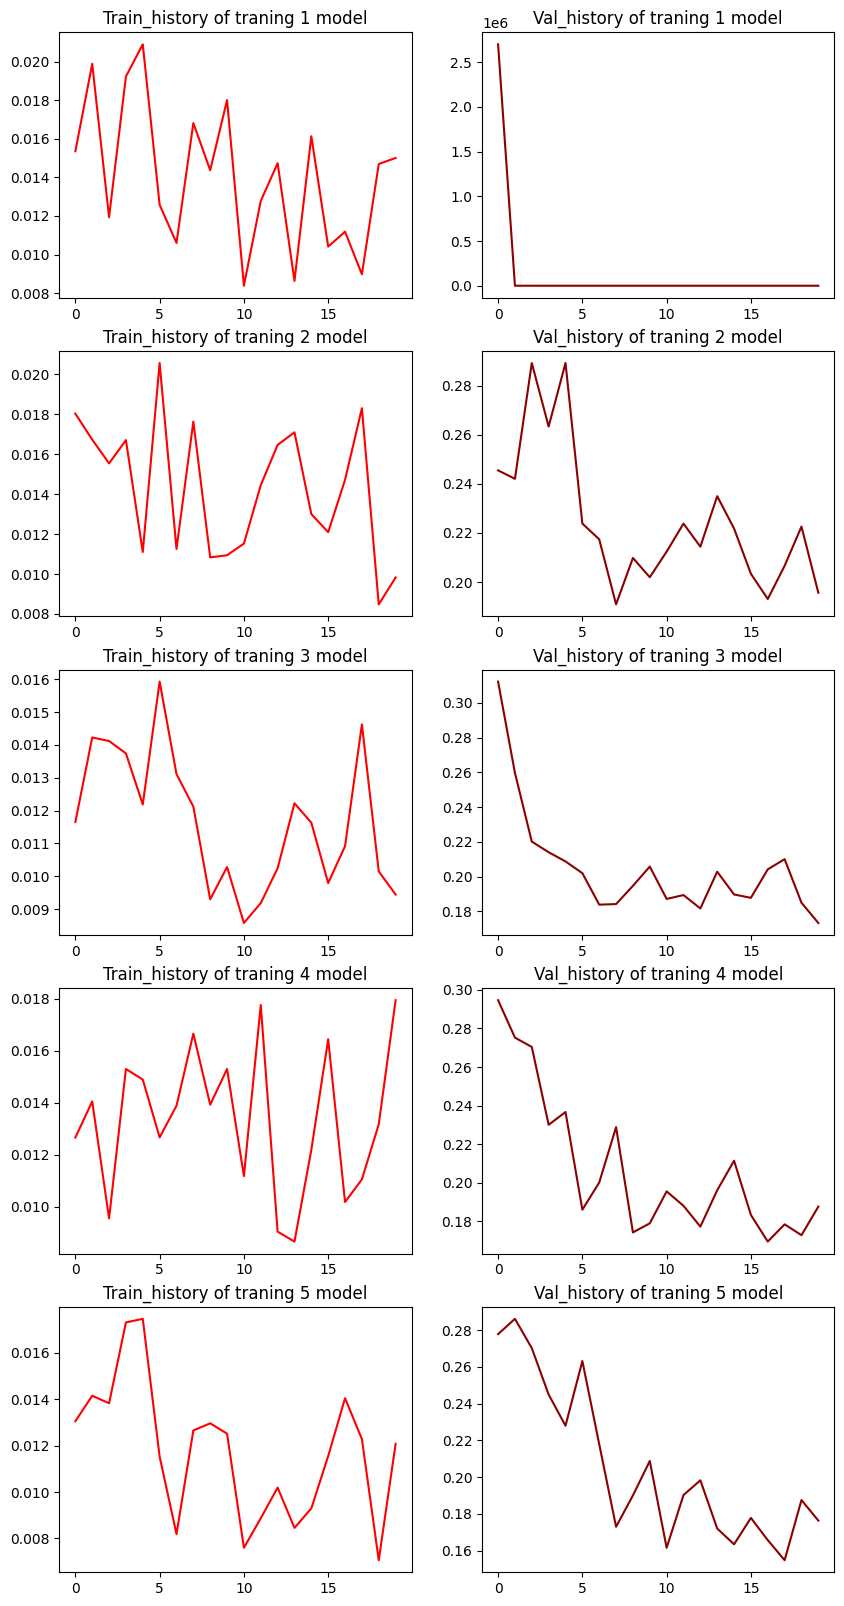

In [ ]:
present_model_train_score(model_train_loss, model_val_loss, MODEL_COUNT)

Из графиков видно, что метрика Dice у 3 модели, сильно изменилась в негативную сторону на 19 - 20 эпохе(При минимальном лоссе).
Я заметил(на предыдущих этапах обучения), что такое бывает за несколько итерации до еще большего уменьшения функции потерь.
Поэтому попробуем дообучить 3 модель

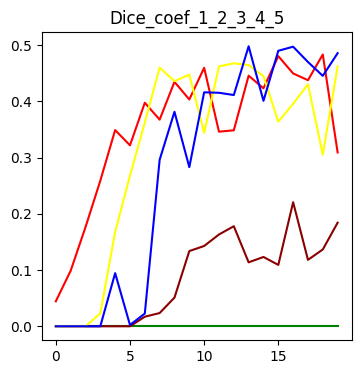

In [ ]:
plt.figure(figsize = (4,4))
plt.plot(search_model.models_train_objct[1].score_class.epoch_val_Dice.values(),color='green')
plt.plot(search_model.models_train_objct[2].score_class.epoch_val_Dice.values(), color='darkred')
plt.plot(search_model.models_train_objct[3].score_class.epoch_val_Dice.values(), color='red')
plt.plot(search_model.models_train_objct[4].score_class.epoch_val_Dice.values(), color='yellow')
plt.plot(search_model.models_train_objct[5].score_class.epoch_val_Dice.values(), color='blue')
plt.title('Dice_coef_1_2_3_4_5')
plt.show()

Видно что у модели DeepLabV3 после 20 эпох обучения маски более шумные, чем у U_Net при 10 эпохах обучения

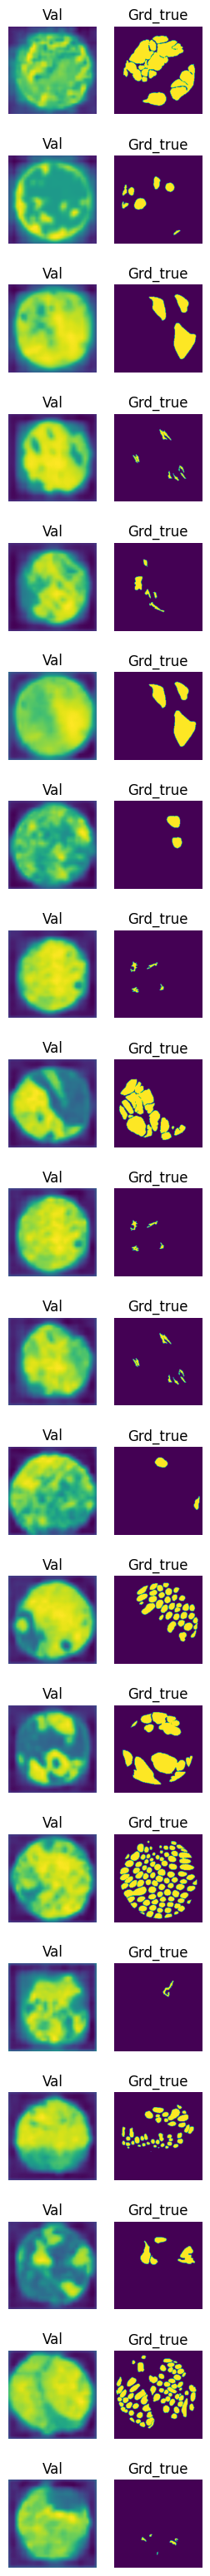

In [ ]:
model_visual_traning_history(search_model.models_train_objct[3].val_predicted, EPOCH_COUNT)

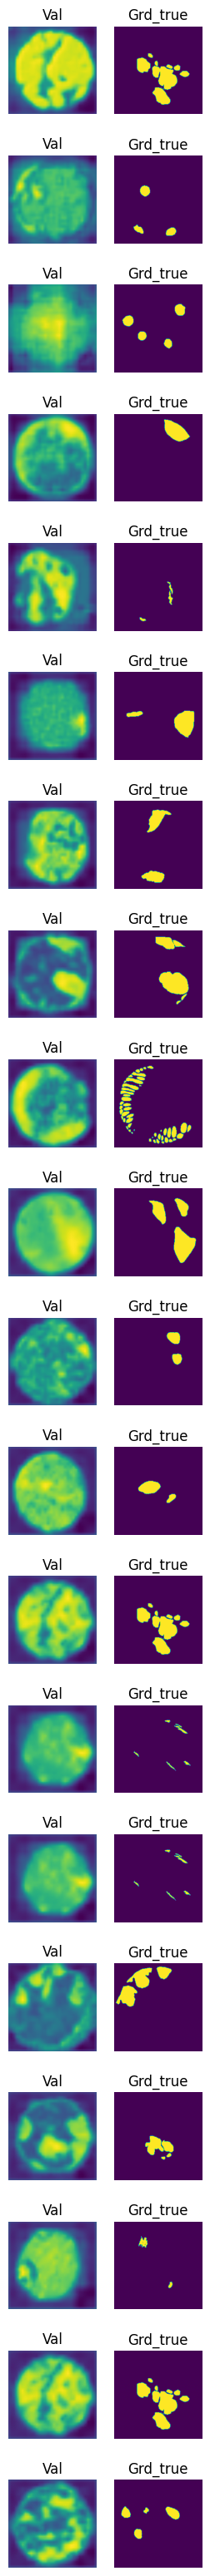

In [ ]:
model_visual_traning_history(search_model.models_train_objct[5].val_predicted, EPOCH_COUNT)

In [ ]:
#  Уменьшил батч, потому что не хватало оперативной памяти 
batch_size = 8

train_df = choice_set(train_csv_data, control_train = True)
val_df = choice_set(train_csv_data, train = False)

train_loader = DataLoader(train_df, batch_size = batch_size, shuffle = True, generator=torch.Generator(device='cuda')) 
val_loader = DataLoader(val_df, batch_size = int(batch_size * 1.5), shuffle = True, generator=torch.Generator(device='cuda'))

In [ ]:
#  Загружаем 3 модель из папки на гугл диске сразу GPU
dicted = torch.load('<>', map_location=torch.device('cuda:0'))

In [ ]:
#  Загружаем параметры модели и оптимизатора 
model_2.load_state_dict(dicted['state_dict'])
model_2.eval()

optimazer = optim.Adam(model_2.parameters())
optimazer.load_state_dict(dicted['optimizer'])

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimazer, gamma=0.8, verbose=False)

In [ ]:
train = Trainer(model_2, loss = None, train_loader = None, val_loader = None, optim = optimazer, shelder = scheduler)

Обучение не завершилось потому что я совершил ошибку в наименовании пути папки, в которую хотел сохранить нейросеть.

Но, как видно из истории обучения, метрика Dice не улучшилась при дообучении на 15 эпохах
Поэтому это не так страшно


In [ ]:
best_model = DoTrainAnotherSet(train, 20, 35, train_loader, val_loader, True)

Loss | 0.017 Dice | 0.360
Start Train: 13:20:30, Epoch - 20, End train 13:21:56
Val_loss | 0.556, Val_dice | 0.461
Loss | 0.020 Dice | 0.358
Start Train: 13:22:14, Epoch - 21, End train 13:23:39
Val_loss | 0.546, Val_dice | 0.461
Loss | 0.016 Dice | 0.335
Start Train: 13:23:56, Epoch - 22, End train 13:25:20
Val_loss | 0.584, Val_dice | 0.418
Loss | 0.016 Dice | 0.363
Start Train: 13:25:38, Epoch - 23, End train 13:27:04
Val_loss | 0.580, Val_dice | 0.425
Loss | 0.016 Dice | 0.351
Start Train: 13:27:22, Epoch - 24, End train 13:28:47
Val_loss | 0.524, Val_dice | 0.484
Loss | 0.018 Dice | 0.351
Start Train: 13:29:05, Epoch - 25, End train 13:30:30
Val_loss | 0.554, Val_dice | 0.451
Loss | 0.018 Dice | 0.367
Start Train: 13:30:49, Epoch - 26, End train 13:32:15
Val_loss | 0.528, Val_dice | 0.483
Loss | 0.020 Dice | 0.367
Start Train: 13:32:34, Epoch - 27, End train 13:34:00
Val_loss | 0.561, Val_dice | 0.443
Loss | 0.013 Dice | 0.329
Start Train: 13:34:19, Epoch - 28, End train 13:35:44


RuntimeError: ignored

#Итоги

Учебные:

+ Научился писать классы для формирования датасета, обучения НС, подсчета метрики Dice, поиска хороших гиперпараметров

+ Научился сохранять параметры НС для последующего обучения

+ Поработал с предтрейн сетями для сегментации(segmentation_models_pytorch) и визуализировал их предсказания


Соревнования:
+ Лучшая метрика Dice, которая у меня была на валидационной выборке - 0.6, 
 
  На соревновании - 0.83. Это ощутимый разрыв


# Выводы

+ Очень много вычислений пропало зря(это я про Random Search). В следующий раз буду использовать алгоритмы, которые ищут хорошие гиперпараметры с оглядкой на историю обучения(Tree-structured Parzen Estimator и байесовская оптимизация)


+ Обучать нейросети нужно сразу на данных с аугментацией, также экспериментировать с размером батча


+ Нужно искать баланс между количеством эпох обучения и количеством моделей. Иногда трудно интерпретировать переобучение нейронной сети. 


+ Сохранять нужно каждую лучшую итерацию обучения(никогда не знаешь в какой момент Google collab перекроет доступ к GPU)

+ Алгоритм делает слишком шумные предсказания. Возможно это из-за того, что у меня слабый энкодер. Он не может полностью отразить сущность картинки. Поэтому декодер плохо восстанавливает данные


+ Истории функций потерь на валидационной и обучающей выборки слишком разнятся. Также значения функции потерь "прыгают" на обучающей выборки(это видно из графиков).
Пока что я не понимаю почему.

+ Архитектура DeepLabV3 показала себя хуже чем U_NET

  Лучший Dice DeepLabV3 - 0.490
  
  Лучший Dice U_NET - 0.602 

+ В общей сложности обучение всех моделей заняло около 7-8 ч 

